###Import Files

In [ ]:
pip install -U "tensorflow>=2.5"

In [2]:
import os
import cv2
import pathlib

import matplotlib
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

import io
import scipy.misc
import numpy as np
from six import BytesIO
import PIL.Image
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

###Utilities

In [3]:

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = PIL.Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = PIL.Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

IMAGES_FOR_TEST = {
  'Beach' : 'models/research/object_detection/test_images/image2.jpg',
  'Dogs' : 'models/research/object_detection/test_images/image1.jpg',
  # By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
  'Naxos Taverna' : 'https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  'Beatles' : 'https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg',
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  'Birds' : 'https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg',
  'Classroom': 'https://news.virginia.edu/sites/default/files/in_person_teaching_ss_header.jpg',
  'Couple': 'https://static01.nyt.com/images/2013/06/28/arts/28SUBSOMEGIRLS-SPAN/28SUBSOMEGIRLS-SPAN-superJumbo-v2.jpg',
  'Friends': '/content/20180718_232321.jpg'
}

COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]

###Dowanlod necessary dependencies

In [ ]:
!git clone --depth 1 https://github.com/tensorflow/models

In [5]:
# !pip install tf-object-detection-util

In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
pip install .

In [7]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

In [8]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

###Load an image

In [9]:

def Select_image(image_name, flip_horizontally, grayscale):

  selected_image = image_name
  flip_image_horizontally = flip_horizontally
  convert_image_to_grayscale = grayscale

  image_path = IMAGES_FOR_TEST[selected_image]
  image_np = load_image_into_numpy_array(image_path)

  # Flip horizontally
  if(flip_image_horizontally):
    image_np[0] = np.fliplr(image_np[0]).copy()

  # Convert image to grayscale
  if(convert_image_to_grayscale):
    image_np[0] = np.tile(
      np.mean(image_np[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

  return image_np




###load pre-trained model weights extract features from input picture

In [10]:

def select_pretrinaed_model(model_name, image_numpy):

  model_handle = ALL_MODELS[model_name]
  hub_model = hub.load(model_handle)

  results = hub_model(image_numpy)
  result = {key:value.numpy() for key,value in results.items()}

  return result


###Define a function to visualize the final image

In [17]:

def Visualize_detected_boxes(
    image_before_detectio,
    image_after_detection,
    mapping_function,
    used_for_video
    ):

  label_id_offset = 0
  image_np_with_detections = image_before_detectio.copy()

  # Use keypoints if available in detections
  keypoints, keypoint_scores = None, None
  if 'detection_keypoints' in image_after_detection:
    keypoints = image_after_detection['detection_keypoints'][0]
    keypoint_scores = image_after_detection['detection_keypoint_scores'][0]

  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      image_after_detection['detection_boxes'][0],
      (image_after_detection['detection_classes'][0] +
       label_id_offset).astype(int),
      image_after_detection['detection_scores'][0],
      mapping_function,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS,
      line_thickness=3)

  plt.figure(figsize=(14,22))
  plt.axis("off")
  # save imgae
  image = PIL.Image.fromarray(image_np_with_detections[0])

  if used_for_video:
    return image
  else:
    image.save(f'/content/new.png')
    plt.imshow(image)

###Test on predefined images

In [12]:
def show_result(model_name,
                mapping_function,
                image_name,
                flip_horizontally,
                grayscale):

  selected_image = Select_image(image_name, flip_horizontally, grayscale)
  extracted_dictionary = select_pretrinaed_model(model_name, selected_image)
  Visualize_detected_boxes(selected_image,
                           extracted_dictionary,
                           mapping_function,
                           False)



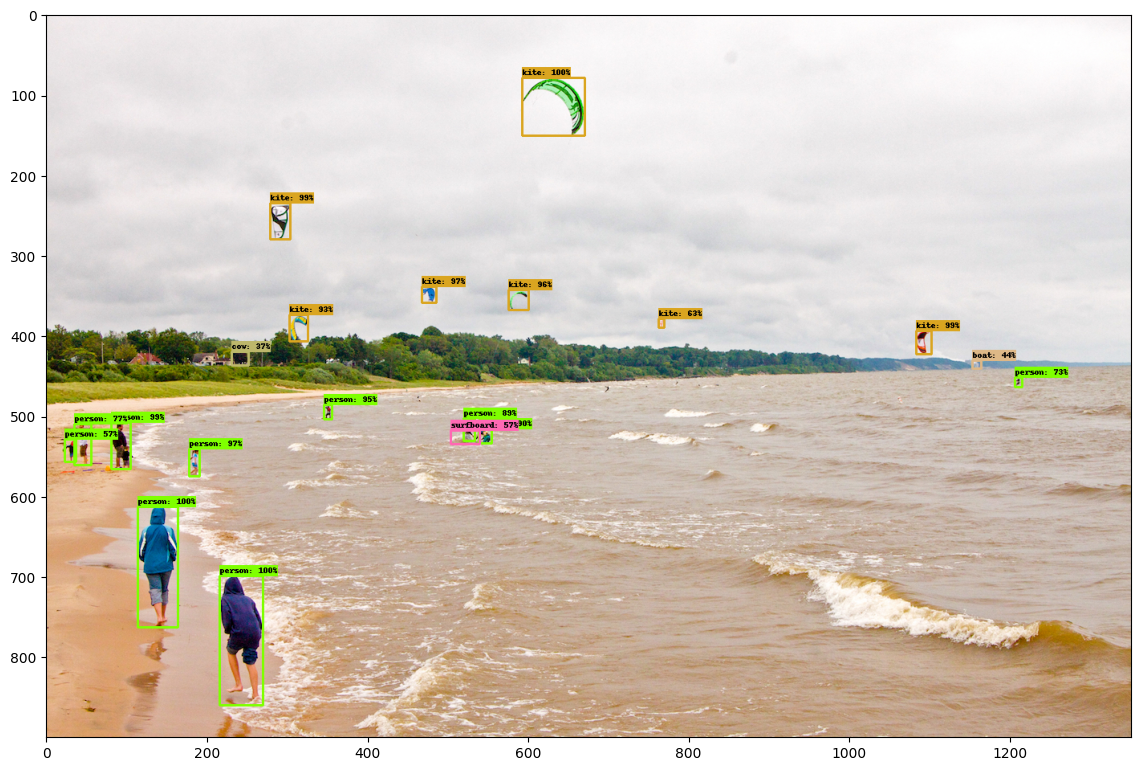

In [13]:
show_result('Faster R-CNN ResNet152 V1 800x1333',
            category_index,
            'Beach', #['Beach', 'Dogs', 'Naxos Taverna', 'Beatles', 'Phones', 'Birds']
            False,
            False)

###Test on new image

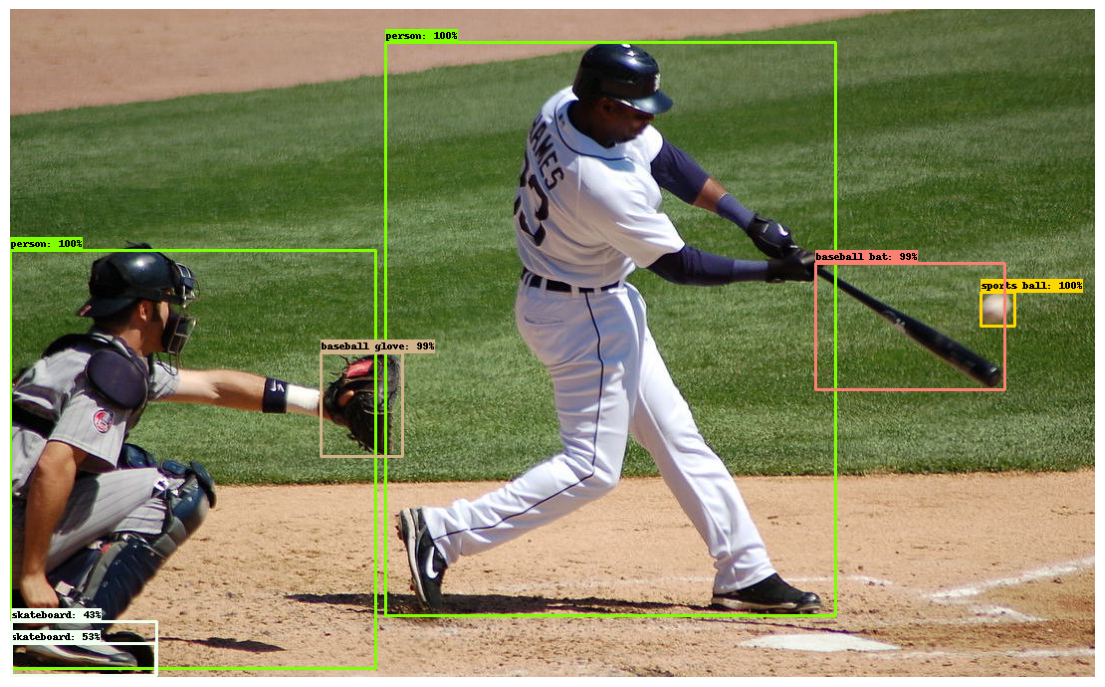

In [24]:
def test_model(test_image_path):
  image_np = load_image_into_numpy_array(test_image_path)

  extracted_dictionary = select_pretrinaed_model(
      'Faster R-CNN ResNet152 V1 800x1333',
      image_np)
  Visualize_detected_boxes(
      image_np,
      extracted_dictionary,
      category_index,
      False)

test_image_path = "/content/baseball.jpg"
test_model(test_image_path)

##Apply object detection for a video

###Connect to Google drive to downalod a few short videos

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
!kaggle datasets download -d mistag/short-videos

In [ ]:
!unzip "/content/short-videos.zip" -d "/content/videos"

###Divide video into frames then apply object detection for each frame

In [ ]:
def Divide_video_to_frames(input_video_path, number_frames):

  # Step 2: Read the video
  cap = cv2.VideoCapture(input_video_path)

  # Step 3: Process frames and create two modified frames
  counter = 0
  output_frames = []
  while counter < number_frames:
      ret, frame = cap.read()
      if not ret:
          break

      frame = frame.reshape(1, 720, 1280, 3)
      # boject detection is called for each frame
      extracted_dictionary = select_pretrinaed_model(
          'Faster R-CNN ResNet152 V1 800x1333', frame)
      processed_frame1 = Visualize_detected_boxes(
          frame,
          extracted_dictionary,
          category_index,
          True)
      # save each frame as an image
      processed_frame1.save(f'/content/Generated/{counter}.png')

      counter += 1



###Created video from new frames

In [ ]:

def Create_video_from_pictures(
    frames_directory,
    output_video_path,
    frame_rate):

    # Get a list of all image files in the frames directory
    frame_files = []
    for f in os.listdir(frames_directory):
        if f.endswith('.jpg') or f.endswith('.png'):
            frame_files.append(f)


    # Sort the frame files to maintain the order
    frame_files.sort()

    # Get the first frame to obtain its dimensions
    # (assuming all frames have the same dimensions)
    first_frame = cv2.imread(os.path.join(frames_directory, frame_files[0]))
    frame_height, frame_width, _ = first_frame.shape

    # Define the codec and frame rate for the output video
    codec = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'XVID' for AVI format

    # Create the VideoWriter object
    video_writer = cv2.VideoWriter(
        output_video_path,
        codec,
        frame_rate,
        (frame_width, frame_height))

    # Write each frame to the video
    for frame_file in frame_files:
        frame_path = os.path.join(frames_directory, frame_file)
        frame = cv2.imread(frame_path)
        video_writer.write(frame)

    # Release the video writer
    video_writer.release()

    print("Video creation complete.")


In [ ]:

# apply object detection on frames
Divide_video_to_frames('/content/videos/food/seafood_1280p.mp4', 100)

# create video from new frames
Create_video_from_pictures("/content/Generated",
                           "/content/result.mp4",
                           30)